# Saving buffers at predefined time points

In [1]:
#pylab
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pylab import imshow, show

import skimage as sk
from skimage import measure, filters

import matplotlib.pyplot as plt, numpy as np, os
from numba import njit, jit, vectorize
from PIL import Image
import imageio
# import cv2 as cv

#automate the boring stuff
from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
# width = 512
# height = 512
# channel_no = 3

#load the libraries
from lib.operari import *
from lib.ProgressBar import *
from lib.minimal_model import *
from lib.TexturePlot import *
from lib.get_tips import *
from lib.minimal_model import *
from lib.intersection import *
#TODO: use cuda via numba
# from numba import jit, njit, vectorize, cuda, uint32, f8, uint8
# from lib.contours_to_tips import *

%autocall 1
%load_ext autoreload
%autoreload 2

100000
Automatic calling is: Smart


# reinitialize with a desired buffer

In [141]:
sigma = 3.  #1.5#1.5#1.#1
threshold = 0.6#0.6  #0.9#0.95
V_threshold = 0.5


# search_for_file()
data_dir = nb_dir + '/Data/initial-conditions/ic_200x200.101.22.npz'
output_fn = f'Log/tip_log_ds_5_sigma_{sigma}_threshold_{threshold}.csv'
save_folder = f'{nb_dir}/Data/ds_5_param_set_8' #no '/Log'
output_file = get_unique_file_name(os.path.join(save_folder, output_fn), ext_string='.csv')





['/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_3.0_threshold_0.6.csv']
incremented file name is - /Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_3.0_threshold_0.6_001.csv


In [142]:
os.chdir(nb_dir)


edge_tolerance = 20
pad = 25
atol = 1e-11
# buffer_fn   = f'buffer_time_origin_primed_with_circle6.npy'
# buffer_fn   = f'buffer_chaos_circle6_sigma_5_threshold_0.6_wrapping_true_at_time_5400.0.npy'
# buffer_fn = 'ic_600x600.101_t_4.npz'
# data_dir = nb_dir+'/Data/ic_600x600.101.npz'
# save_folder = 'Data/buffers_with_odd_tips_detected_ds_5_param_set_8'

# output_dir = get_unique_dir(path)
#deprecated
# output_dir = os.path.join(nb_dir, save_folder)
# if not os.path.exists(output_dir):
#     os.mkdir(output_dir)
# output_dir = os.path.join(nb_dir, save_folder) + '/Log'
# if not os.path.exists(output_dir):
#     os.mkdir(output_dir)

time_start = 0.  #eval(buffer_fn[buffer_fn.find('time_')+len('time_'):-4])
# descrip     = f"chaos_circle6_from_{time_start:.1f}_sigma_{sigma}_threshold_{threshold}_"
# data_dir    = find_files(buffer_fn,nb_dir)
# if len(data_dir)==0:
#     print("buffer not found.")
# data_dir = data_dir[0]
# data_dir    = f'{nb_dir}/Data/ic_600x600.101.npz'
# txt = np.load(data_dir)
# txt = np.load(f'Data/buffer_chaos_circle6_sigma_5_threshold_0.6_wrapping_true_at_time_5400.0.npy')

assert (float(time_start) is not None)
print(f'loading initial conditions from: \n\t{data_dir}.')
os.chdir(nb_dir)
txt = load_buffer(data_dir)
width, height, channel_no = txt.shape

#reinitialize records
tip_state_lst = []
tme = time_start

#make file for logging results
# output_file = get_incremented_output_filename(output_dir, output_fn)
# os.chdir(nb_dir + '/' + save_folder)
os.chdir(save_folder)
print(f"save_folder is: \n\t{output_file}.")

loading initial conditions from: 
	/Users/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions/ic_200x200.101.22.npz.
save_folder is: 
	/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_3.0_threshold_0.6_001.csv.


In [143]:
#make the texture twice as large making the domain size effectively 10 x 10 cm^2
# txt = pad_texture(txt, pad=100)
# width, height, channel_no = txt.shape

for channel 0,
	max value: 1.0024964739532993
	min value: 0.0031723504029593412
	mean value: 0.5415707649488976
	
for channel 1,
	max value: 0.8914931870573866
	min value: 5.584239969337459e-05
	mean value: 0.19461359905692205
	
for channel 2,
	max value: 0.968801498477279
	min value: 0.7242302012410536
	mean value: 0.8721779207523997
	
max value of change for each channel is 1.0025 , 0.8915, 0.9688.
max rate of change for each channel is 1.9765 , 0.0247, 0.0067.

 number of type 1 contour = 10,	number of type 2 contour = 13,
the number of tips are 8. time is 0.0 ms.


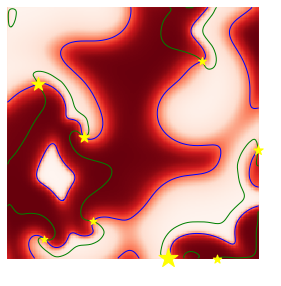

In [144]:
# check all the functions work/ compile the needed functions
zero_txt = txt.copy()*0.
time_step(txt, h=0.007, zero_txt=zero_txt)
# sigma       = 2
# threshold   = 0.95#0.95

describe(txt)
width, height, channel_no = txt.shape
zero_txt = np.zeros((width, height, channel_no), dtype=np.float64)
dtexture_dt = zero_txt.copy()
get_time_step(txt, dtexture_dt)

#calculate contours and tips while enforcing pbcs
padded_txt, dpadded_txt_dt = textures_to_padded_textures(txt, dtexture_dt,pad=pad)
img_nxt = padded_txt#txt[..., 0]
img_inc = ifilter(dpadded_txt_dt) #ifilter(dtexture_dt[..., 0])  #mask of instantaneously increasing voltages 
img_inc = filters.gaussian(img_inc,sigma=sigma)#, mode='wrap') messes up padded tips
contours_raw = measure.find_contours(img_nxt, level=V_threshold,fully_connected='low',positive_orientation='low')
contours_inc = measure.find_contours(img_inc, level=threshold)
tips  = get_tips(contours_raw, contours_inc)
tips_mapped = map_pbc_tips_back(tips=tips, pad=pad, width=width, height=height, 
                  edge_tolerance=edge_tolerance, atol = atol)
n_old = count_tips(tips_mapped[2])

#bluf
print('max value of change for each channel is {:.4f} , {:.4f}, {:.4f}.'.format(*tuple(np.max(txt,axis=(0,1)))))
print('max rate of change for each channel is {:.4f} , {:.4f}, {:.4f}.'.format(*tuple(np.max(dtexture_dt,axis=(0,1)))))

print(f"\n number of type 1 contour = {len(contours_raw)},\tnumber of type 2 contour = {len(contours_inc)},")
print(f"the number of tips are {n_old}. time is {tme:.1f} ms.")

# print(f"""the topological tip state:{tips[0]}""")
# print(f"""x position of tips: {tips[1]}""")
# print(f"""y position of tips: {tips[2]}""")

#plot texture contours and tips. oh my!
img_nxt_unpadded = img_nxt[pad:-pad,pad:-pad]
img_inc_unpadded = img_inc[pad:-pad,pad:-pad]
contours_raw_unpadded = measure.find_contours(img_nxt_unpadded, level=V_threshold,fully_connected='low',positive_orientation='low')
contours_inc_unpadded = measure.find_contours(img_inc_unpadded, level=threshold)

fig = plot_buffer(img_nxt_unpadded, img_inc_unpadded, contours_raw_unpadded, contours_inc_unpadded, tips_mapped, 
                  figsize=(5,5),max_marker_size=400, lw=1);
plt.show()

In [145]:
# fig.savefig('origin_circle6.pdf', bbox_inches='tight',pad_inches=0)
plt.close()

In [146]:
ds =5 #not used, I think
tme

0.0

# run the simulation

In [147]:
h = 0.007
nsteps = 1*10**5 # int(1.8*10**5)#0#*10**4
save_every_n_frames = 1#nsteps#100#nsteps#10#50
print( f"integrating up to time {h*nsteps+tme:.2f} milliseconds.")

integrating up to time 700.00 milliseconds.


In [148]:
#integrate explicitely in time
time_sig_figs = 3  #you need to change this manually below for pretty printing only!
start = time.time()
max_buffers_to_save = 10
buffers_saved = 0
start_saving_buffers_at_step = 0#10**4 # nsteps/4
# tip_states = None
timing = False
recording_if_odd = True
recording = True
state = np.zeros((txt.shape[0],txt.shape[1],4),dtype=np.float64)
descrip = f'sigma_{sigma}_threshold_{threshold}'
print(f"sigma is {sigma}, threshold is {threshold}.")
print(f"pad is {pad}, rejection_distance is edge_tolerance is {edge_tolerance}.")
print(f"starting simulation.  integrating up to time {h*nsteps+tme:.3f} milliseconds.")
for step in range(nsteps):
    recording = step%save_every_n_frames==0
    if not recording:
        #integrate explicitely in time
        time_step(txt, h=h, zero_txt=zero_txt) #up to twice as fast as for separated calls
        tme += h
    if recording:
        #calculate discrete flow map
        dtexture_dt = zero_txt.copy()
        get_time_step(txt, dtexture_dt)
        
        #pad texture for saving view 
        padded_txt, dpadded_txt_dt = textures_to_padded_textures(txt, dtexture_dt,pad=pad)
        
        #integrate explicitely in time by the forward euler method
        txt += h*dtexture_dt
        tme += h
        
        #calculate contours and tips while enforcing pbcs
        padded_txt, dpadded_txt_dt = textures_to_padded_textures(txt, dtexture_dt,pad=pad)
        img_nxt = padded_txt #txt[..., 0]
        img_inc = ifilter(dpadded_txt_dt) #ifilter(dtexture_dt[..., 0])  #mask of instantaneously increasing voltages 
        img_inc = filters.gaussian(img_inc,sigma=sigma)#, mode='wrap') messes up padded tips
        contours_raw = measure.find_contours(img_nxt, level=V_threshold,fully_connected='low',positive_orientation='low')
        contours_inc = measure.find_contours(img_inc, level=threshold)
        tips  = get_tips(contours_raw, contours_inc)
        tips_mapped = map_pbc_tips_back(tips=tips, pad=pad, width=width, height=height, 
                          edge_tolerance=edge_tolerance, atol = atol) # large pads gives more positional precision.

        #record spiral tip locations 
        s1_lst, s2_lst, x_lst, y_lst = tips_mapped
        tip_state_lst.append({
                    't': float(np.around(tme, time_sig_figs)),
                    'x': tuple(x_lst),
                    'y': tuple(y_lst),
                    's1': tuple(s1_lst),
                    's2': tuple(s2_lst)})
        
        #determine if an odd number of tips were born        
        n = count_tips(tips_mapped[2]) #counts the number of '.' in the nested list of x positions or just a normal list
        dn = n - n_old
        n_old = n
        
        #save the state if save_state is True 
        #save_state = recording_if_odd & odd_event & odd_tip_number # ==> odd birth/death event has just occurred
        save_state = recording_if_odd & (dn%2!=0) & (n%2!=0)
        if save_state:
            #plot texture contours and tips. oh my!
            img_nxt_unpadded = img_nxt[pad:-pad,pad:-pad]
            img_inc_unpadded = img_inc[pad:-pad,pad:-pad]
            contours_raw_unpadded = measure.find_contours(img_nxt_unpadded, level=V_threshold,fully_connected='low',positive_orientation='low')
            contours_inc_unpadded = measure.find_contours(img_inc_unpadded, level=threshold)
            print(f'odd tip spotted at time {tme:.3f}! dn={dn} and n={n}...')
            fig = plot_buffer(img_nxt_unpadded, img_inc_unpadded, contours_raw_unpadded, contours_inc_unpadded, tips_mapped, 
                              figsize=(5,5), max_marker_size=200, lw=1);
            fig.savefig(f'plot_of_n_{n}_dn_{dn}_for_{descrip}_at_time_{tme:.1f}.pdf', bbox_inches='tight',pad_inches=0);
            plt.close();
            #save texture as an .npy file as desired
            if step>start_saving_buffers_at_step:
                if buffers_saved<max_buffers_to_save:
                    buffers_saved += 1
                    np.save(f'buffer_of_n_{n}_dn_{dn}_for_{descrip}_at_time_{tme:.1f}.npy', txt)
        #early stopping when spirals die out
        stop_early = (n==0) & (step>100) #np.max(txt[...,0])<0.1
        if stop_early:
            print(f'\nmax voltage is {np.max(txt[...,0]):.4f}.') 
            print(f"tip number = {n}.  stopping simulation at time t={tme:.3f}. please record domain size.")
            break
    printProgressBar(step + 1, nsteps, prefix = 'Progress:', suffix = 'Complete', length = 50)

#report the bottom line up front
print(f"\ntime integration complete. time elapsed was {time.time()-start:.2f} seconds")
print(f"current time is {tme:.1f} ms.")
print(f"number of nan pixel voltages is {np.max(sum(np.isnan(txt[...,0])))}.")
print(f"current max voltage is {np.nanmax(txt[...,0]):.4f}.")
print(f"current max fast variable is {np.nanmax(txt[...,1]):.4f}.")
print(f"current max slow variable is {np.nanmax(txt[...,2]):.4f}.")
# n_lst, x_lst, y_lst = get_tips(contours_raw, contours_inc)
# tip_states = {'n': n_lst, 'x': x_lst, 'y': y_lst}
# print(f"tip_states are {tip_states}.")
# print(f'current tip state is {tip_states}')
# if len(lst)~=0:
# print(f"number of tips is = {set([len(q) for q in lst_x[-1]])}.") #most recent number of tips

if recording:
    print(f"\n number of type 1 contour = {len(contours_raw)},\tnumber of type 2 contour = {len(contours_inc)},")
    print(f"the number of tips are {count_tips(tips_mapped[2])}.")
    #     print(f"""the topological tip state is the following:{tips[0]}""")
beep(3)

sigma is 3.0, threshold is 0.6.
pad is 25, rejection_distance is edge_tolerance is 20.
starting simulation.  integrating up to time 700.000 milliseconds.
Progress: |███████████████████████████████████████-----------| 79.6% Complete
max voltage is 1.0024.
tip number = 0.  stopping simulation at time t=557.067. please record domain size.

time integration complete. time elapsed was 9048.38 seconds
current time is 557.1 ms.
number of nan pixel voltages is 0.
current max voltage is 1.0024.
current max fast variable is 0.9281.
current max slow variable is 0.9918.

 number of type 1 contour = 2,	number of type 2 contour = 2,
the number of tips are 0.


0

the time is 557.1 ms.
the number of tips are 0.


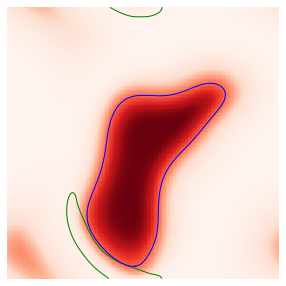

In [139]:
# sigma       = 1.#1.5#1.#1
# threshold   = 0.6#0.9#0.95
# V_threshold = 0.5

# edge_tolerance = 3
# pad = 10

#calculate contours and tips while enforcing pbcs
padded_txt, dpadded_txt_dt = textures_to_padded_textures(txt, dtexture_dt,pad=pad)
img_nxt = padded_txt#txt[..., 0]
img_inc = ifilter(dpadded_txt_dt) #ifilter(dtexture_dt[..., 0])  #mask of instantaneously increasing voltages 
img_inc = filters.gaussian(img_inc,sigma=sigma)#, mode='wrap') messes up padded tips
contours_raw = measure.find_contours(img_nxt, level=V_threshold,fully_connected='low',positive_orientation='low')
contours_inc = measure.find_contours(img_inc, level=threshold)
tips  = get_tips(contours_raw, contours_inc)
tips_mapped = map_pbc_tips_back(tips=tips, pad=pad, width=width, height=height, edge_tolerance=edge_tolerance, atol = 1e-11)

#plot textures, contours and tips. oh my!
img_nxt_unpadded = img_nxt[pad:-pad,pad:-pad]
img_inc_unpadded = img_inc[pad:-pad,pad:-pad]
contours_raw_unpadded = measure.find_contours(img_nxt_unpadded, level=V_threshold,fully_connected='low',positive_orientation='low')
contours_inc_unpadded = measure.find_contours(img_inc_unpadded, level=threshold)
print(f"the time is {tme:.1f} ms.")
print(f"the number of tips are {count_tips(tips_mapped[2])}.")

fig = plot_buffer(img_nxt_unpadded, img_inc_unpadded, contours_raw_unpadded, contours_inc_unpadded, tips_mapped, 
                  figsize=(5,5),max_marker_size=400, lw=1);
plt.show()
# fig.savefig(f'{nb_dir}/Figures/ic_200x200.101.22_t_557.7.svg', bbox_inches='tight',pad_inches=0);
            

## save tip log

In [131]:
print(output_file)

/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_3.0_threshold_0.9.csv


In [140]:
save = True
#this saving overwrites the current save_file
if save:
    df = pd.DataFrame(tip_state_lst)
    df.to_csv(output_file, index=False)
#     df.to_csv(f'{nb_dir}/Data/tip_log_{descrip}_at_time_{tme:.1f}.csv', index=False)
print('saved to:')
print(output_file)
# print(f'Data/tip_log__{descrip}_at_time_{tme:.1f}.csv')

saved to:
/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_3.0_threshold_0.6.csv


# save buffer for later initialization

In [71]:
save = True
save_buffer_fn = f'{nb_dir}/Data/ic_200x200.101.22_t_{tme:.1f}.npz'
if save:
    np.savez_compressed(save_buffer_fn, txt)
    print('saved to:')
print(save_buffer_fn)

saved to:
/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ic_200x200.101.22_t_557.7.npz


## save plot of buffer/contours/tips

the tip at x = 99.82786411231851 and y = 6.925621859371876 was missed for pad - edge_tolerance = 7.  It was detected by get_tips but not returned by map_pbc_tips_back.
Bug fixed
if X < -pad+P:
was erroneously 
if X < pad-P:
in unpad(.)

In [ ]:
#view/save the buffer with contours and tips plotted
save = False
save_file_name = f'buffer_{descrip}_at_time_{tme:.1f}'
save_dir = f"{nb_dir}/Figures/{save_file_name}.png"
image = txt.copy()

# experiment with different sigma and threshold
sigma       = 5/18*2#1
threshold   = 0.95


#compute display data
h = 0.1
# state = np.zeros((512,512,4),dtype=np.float64)
# get_tissue_state(texture=txt, out=state[...])
dtexture_dt = zero_txt.copy()
get_time_step(txt, dtexture_dt)
img_nxt = txt[...,0].copy()
img_inc = txt[...,0].copy()
#plot figure
plt.figure(figsize=(15,15))
plt.imshow(img_nxt,cmap='Reds', vmin=0, vmax=1)
# plt.title("voltage increases with red", fontsize=24)

#plot contours, if any.  type 1 = contours_raw, type 2 = contours_inc
img_inc = ifilter(dtexture_dt[..., 0])  #mask of instantaneously increasing voltages 
img_inc = filters.gaussian(img_inc,sigma=sigma, mode='wrap')
contours_raw = measure.find_contours(img_nxt, level=0.5,fully_connected='low',positive_orientation='low')
contours_inc = measure.find_contours(img_inc, level=threshold,fully_connected='low',positive_orientation='low')
for n, contour in enumerate(contours_inc):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2, c='g', zorder=2)
for n, contour in enumerate(contours_raw):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2, c='b', zorder=2)
plt.axis('off')

#plot tips, if any
tips = get_tips(contours_raw, contours_inc)
n_values, y_values, x_values = tips
for j in range(len(tips[2])): #nota bene, tips[2] is x_values
    plt.scatter(x = tips[2][j], y = tips[1][j], c='yellow', s=int(800/(j+1)), zorder=3, marker = '*')
print(f"current time is {tme:.1f}")
print(f"number of type 1 contour = {len(contours_raw)},\tnumber of type 2 contour = {len(contours_inc)},")
print(f"""the topological tip state is the following: {n_values}""")
print(f"""x coords: {x_values}""")
print(f"""y coords: {y_values}""")
if save:
    plt.savefig(save_dir)
#     np.save(f'Data/{save_file_name}.npy', image)
    print('file saved at')
#     print(f'Data/{save_file_name}.npy')
#     np.savez_compressed(f'Data/{save_file_name}.npz', image)
else:
    plt.show()

In [ ]:


# n_lst, x_lst, y_lst = get_tips(contours_raw, contours_inc)
# tip_states = {'n': n_lst, 'x': x_lst, 'y': y_lst}

# fig = plot_buffer(img_nxt, img_inc, contours_raw, contours_inc, tips, 
#                   figsize=(5,5),max_marker_size=200, lw=1);
# fig.show()
beep(1)

In [ ]:
plt.close()

# bigger domains can have larger step sizes
#Numerical stability requires small enough time step 
$$h\le0.01 ms \cdot\frac{\text{domain size}}{18 cm}$$

I noticed ^this after changing domain size from 18 cm to 5 cm.  I was using explicit forward euler integration through time.
- step 1, developed quick way to reproduce behavior
- step 2, saw if behavior persists for old parameter set/
    - $\rightarrow$ ^this tells me if the bug is in the code or in the parameters...
    
* So for a domain size of ds_x = 5 #cm, use a time step of h = 0.002.

In [51]:
import inspect


In [10]:
# print(inspect.getsource(time_step_at_pixel))

# scratch from helper functions: 
TODO: make simple tests for them and other helper functions.  Put those tests in a nice .py function or using a nice pytest-like notebook

In [3]:
# #TODO: list the time points that I'd like to save at.  make a folder to put them in
# #TODO: copy the 'generating tips'.  slim it down.  make it's time consistent with the predefined origin
# #TODO: edit it to save at those time points (i) buffers and (ii) .png with contours and tips indicated
# def count_tips(x_list):
#     return str(x_list).count('.')

# def find_files(filename, search_path):
#     result = []
#     for root, dir, files in os.walk(search_path):
#         if filename in files:
#             result.append(os.path.join(root, filename))
#     return result
# # def plot_buffer(img_nxt, img_inc, contours_raw, contours_inc, tips, dpi, figsize=(15,15)):
# def plot_buffer(img_nxt, img_inc, contours_raw, contours_inc, tips, figsize=(15,15), max_marker_size=800, lw=2):
#     '''computes display data; returns fig.'''
#     #plot figure
#     fig, ax = plt.subplots(1,figsize=figsize)
#     ax.imshow(img_nxt,cmap='Reds', vmin=0, vmax=1)
#     ax.axis('off')

#     #plot contours, if any.  type 1 = contours_raw (blue), type 2 = contours_inc (green)
#     for n, contour in enumerate(contours_inc):
#         ax.plot(contour[:, 1], contour[:, 0], linewidth=lw, c='g', zorder=2)
#     for n, contour in enumerate(contours_raw):
#         ax.plot(contour[:, 1], contour[:, 0], linewidth=lw, c='b', zorder=2)

#     #plot tips, if any
#     n_values, y_values, x_values = tips
#     #     if len(n_values)>0:
#     for j in range(len(x_values)): 
#         ax.scatter(x = x_values[j], y = y_values[j], c='yellow', s=int(max_marker_size/(j+1)), zorder=3, marker = '*')
#     return fig

# Compressing WJ's example initial conditions to 28% of original file size 
- data type uneffected.  still float64
- ^his ic's didn't produce spiral defect chaos.

In [71]:
data_dir = f'{nb_dir}/Data/ic_600x600.101'
assert(os.path.exists(data_dir))
txt = np.loadtxt(data_dir)
txt = txt.reshape(600,600,3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


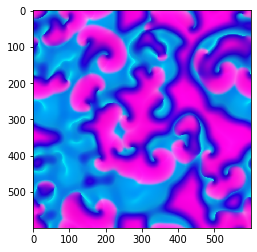

In [72]:
plt.imshow(txt)

In [73]:
print(txt.dtype)
describe(txt)

float64
for channel 0,
	max value: 1.0191668451289984
	min value: 0.0002091044690747812
	mean value: 0.4273355540736459
	
for channel 1,
	max value: 0.939233331559598
	min value: 2.524558960720931e-08
	mean value: 0.2652040224232269
	
for channel 2,
	max value: 0.9890739569674408
	min value: 0.6557470028121303
	mean value: 0.8796223397282353
	


In [74]:
np.savez_compressed(f'{nb_dir}/Data/ic_600x600.101.npz', txt)

In [63]:
f'{nb_dir}/Data/ic_600x600.101.npz'
txt = np.load(data_dir)['arr_0']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


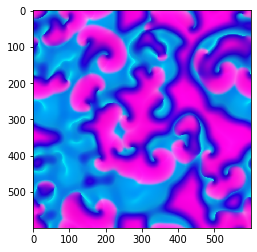

In [69]:
plt.imshow(A['arr_0'])

In [70]:
print(txt.dtype)
describe(txt)

float64
for channel 0,
	max value: 1.0191668451289984
	min value: 0.0002091044690747812
	mean value: 0.4273355540736459
	
for channel 1,
	max value: 0.939233331559598
	min value: 2.524558960720931e-08
	mean value: 0.2652040224232269
	
for channel 2,
	max value: 0.9890739569674408
	min value: 0.6557470028121303
	mean value: 0.8796223397282353
	


0.2852112676056338

In [10]:
# # @njit
# def unpad2(X, pad, width, rejection_distance):
#     '''unpads 1 coordinate x or y for the padding: 
#     [0... pad | pad ... width + pad | width + pad ... width + 2 * pad]
#     return -9999 if X is within rejection_distance of the edge,
#     return X if X is in [pad ... width + pad], which is if X is in the unpadded frame, which has width = width
#     else return X reflected onto the unpadded frame'''
#     P  = rejection_distance
#     X -= pad
#     if X < -pad+P:
#         X = -9999 # throw out X later
#     elif X < 0:
#         X += width
#     if X > width+pad-P:
#         X = -9999 # throw out X later
#     elif X >= width:
#         X -= width
#     return X

In [83]:
# X = 99.82786411231851+pad; Y = 6.925621859371876+pad
# unpad2(X=Y, pad=pad, width=height, rejection_distance=0)#edge_tolerance)

6.925621859371876

In [8]:
tips

tips_mapped

([(0, 0)], [[0.17883012194683978]], [[104.10981494161571]])